### **Data loading**

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print("Path to dataset files:", path)

file_path = f"{path}/housing.csv"
housing_data = pd.read_csv(file_path)

100%|██████████| 400k/400k [00:00<00:00, 19.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/camnugent/california-housing-prices/versions/1


### **Data Processing**

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the housing dataset from a CSV file.
    Args:
        file_path (str): Path to the CSV file containing the dataset.
    Returns:
        tuple: Feature matrix (X) and target variable (y).
    """
    # Load the dataset
    data = housing_data

    # Handle missing values
    median_bedrooms = data['total_bedrooms'].median()
    data['total_bedrooms'].fillna(median_bedrooms, inplace=True)

    # Separate features and target
    X = data.drop(columns=['median_house_value'])
    y = data['median_house_value']

    # One-hot encode categorical features
    categorical_columns = ['ocean_proximity']
    encoder = OneHotEncoder()
    encoded_categorical = encoder.fit_transform(data[categorical_columns]).toarray()

    # Scale numerical features
    numerical_columns = X.columns.difference(categorical_columns)
    scaler = StandardScaler()
    scaled_numerical = scaler.fit_transform(data[numerical_columns])

    # Combine processed features
    X = np.hstack([scaled_numerical, encoded_categorical])

    # Check for missing values
    print("\nMissing values check:")
    print(data.isnull().sum())

    return X, y

def plot_results(y_test, y_pred, metrics):
    """Create visualization of actual vs predicted values."""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Prices', fontsize=14)
    plt.ylabel('Predicted Prices', fontsize=14)
    plt.title('Actual vs Predicted Housing Prices', fontsize=16, weight='bold')
    plt.xticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Load and preprocess data
file_path = '/mnt/data/housing.csv'  # Replace with the correct file path
X, y = load_and_preprocess_data(file_path)

# Split data
def split_and_scale_data(X, y):
    """Split the data into training and testing sets."""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split_and_scale_data(X, y)


Missing values check:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


<ipython-input-22-4b235a329de9>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['total_bedrooms'].fillna(median_bedrooms, inplace=True)


### **Lasso Regression model Training & Evaluation**

In [20]:
# Train and evaluate initial model
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    """Train and evaluate the Lasso Regression model."""
    # Initialize and train the model with default parameters
    lasso = Lasso(random_state=42)
    lasso.fit(X_train, y_train)

    # Make predictions
    y_train_pred = lasso.predict(X_train)
    y_test_pred = lasso.predict(X_test)

    # Calculate metrics
    metrics = {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }

    return lasso, metrics
lasso_model, metrics = train_and_evaluate_model(
    X_train, X_test, y_train, y_test
)
# Print initial model metrics
print("\nInitial Model Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")


Initial Model Metrics:
Train RMSE: 68433.9681
Test RMSE: 70061.6521
Train R2: 0.6497
Test R2: 0.6254
Train MAE: 49595.2394
Test MAE: 50671.9444


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.266e+12, tolerance: 2.207e+10
  model = cd_fast.enet_coordinate_descent(


### **Perform hyperparameter tuning**

In [15]:
def optimize_hyperparameters(X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV."""
    # Define parameter grid
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    }

    # Initialize GridSearchCV
    lasso = Lasso(random_state=42, max_iter=10000)
    grid_search = GridSearchCV(
        lasso, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    return grid_search
# Perform hyperparameter tuning
grid_search = optimize_hyperparameters(X_train, y_train)

# Print best parameters and score
print("\nHyperparameter Tuning Results:")
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best cross-validation RMSE: {np.sqrt(-grid_search.best_score_):.4f}")


Hyperparameter Tuning Results:
Best alpha: 0.1
Best cross-validation RMSE: 68637.6153


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.263e+12, tolerance: 2.207e+10
  model = cd_fast.enet_coordinate_descent(


### **Visualization of model prediction results**

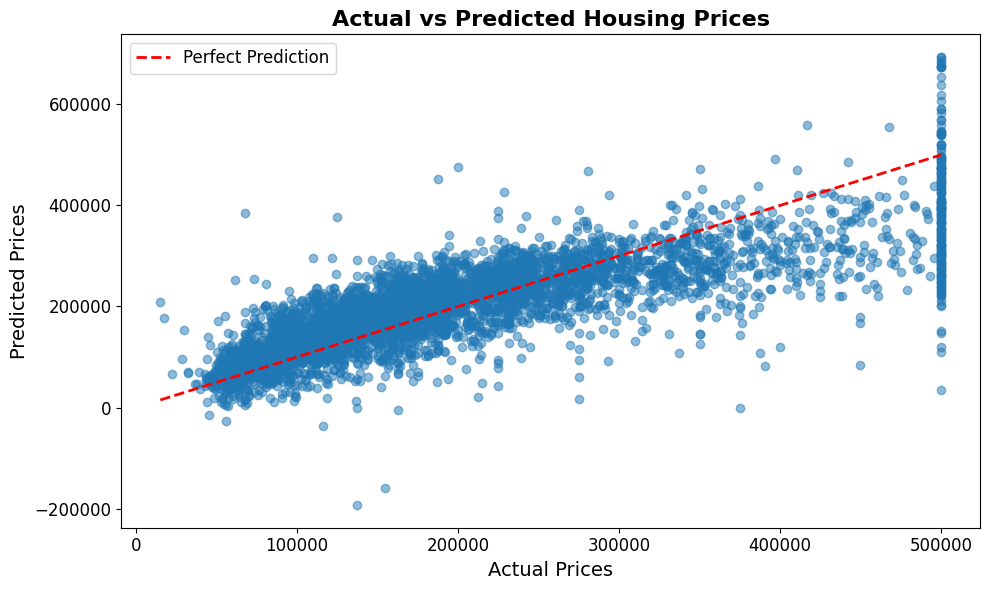

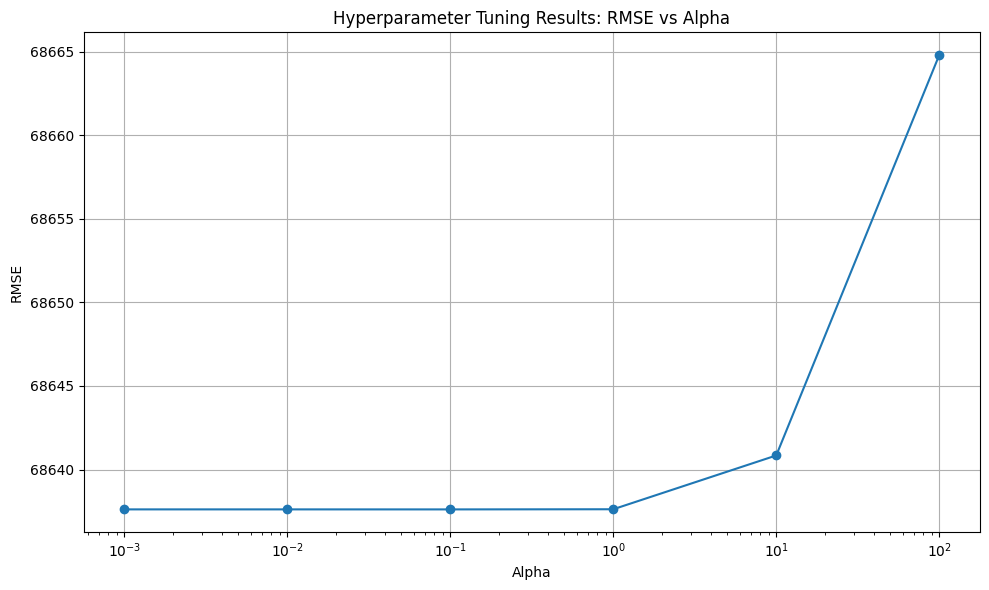

In [23]:
# Make predictions with optimized model
y_pred = grid_search.best_estimator_.predict(X_test)

# Plot results
plot_results(y_test, y_pred, metrics)

def plot_hyperparameter_tuning_results(grid_search):
    """Plot the RMSE vs alpha values from GridSearchCV results."""
    # Extract results into a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)

    # Convert alpha values to float
    results['alpha'] = results['param_alpha'].astype(float)

    # Calculate RMSE from negative mean test score
    results['RMSE'] = np.sqrt(-results['mean_test_score'])

    # Sort results by alpha for consistent plotting
    results = results.sort_values('alpha')

    # Plot RMSE vs alpha
    plt.figure(figsize=(10, 6))
    plt.plot(results['alpha'], results['RMSE'], marker='o')
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('RMSE')
    plt.title('Hyperparameter Tuning Results: RMSE vs Alpha')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_hyperparameter_tuning_results(grid_search)